Bitcoin Transaction 데이터 EDA
---------------
[1. Dataset 설명](#1)   
- [bitcoin transaction](#1-1)  
- [data dictionary](#1-2)  

[2. EDA](#2)
- [transaction amount와 input을 구성하는 UTXO 길이](#2-1)
- [transaction amount in BTC vs. transaction count in time series](#2-2)
- [script가 RETURN인 transaction 살펴보기](#2-3)

<a name='1'></a>
## 1. Dataset 설명
BigQuery 사용을 위해 GCP 접근 설정을 했으면 (GCP 설정은 [블로그 글](http://suewoonryu.com/2018/02/04/bigquery-bitcoin/) 참고), 이제 `google.cloud`라이브러리를 사용해서 BigQuery 퍼블릭 데이터 셋을 활용 할 수 있다. 먼저 데이터셋에 있는 거래 데이터의 일부를 json으로 저장한 파일을 불러와서 `bigquery-public-data.bitcoin_blockchain.transactions`가 어떻게 구성되어있는지 보자.

In [2]:
import json
from pprint import pprint

with open('tx.json') as data_file:    
    data = json.load(data_file)

In [3]:
# Keys - Columns on table 
print("Columns: ")
print(data[0].keys())
print()

# Inputs 
print("Inputs: ")
pprint(data[0]['inputs'])
print()

# Outputs
print("Outputs: ")
pprint(data[0]['outputs'])

Columns: 
dict_keys(['timestamp', 'transaction_id', 'inputs', 'outputs', 'block_id', 'previous_block', 'merkle_root', 'nonce', 'version', 'work_terahash', 'work_error'])

Inputs: 
[{'input_pubkey_base58': '1Ns9hUC2hrE1HARb1EgUJQuDezDdaaNjM5',
  'input_pubkey_base58_error': None,
  'input_script_bytes': 'SDBFAiAblvuJtZykYST+J2kPoTVmEaJL22f16xL7DpTtVe4qNgIhAKMS6zUpr8N8saHkTf4KHlIgmoX+NZ3qffubPvmaz+19ASECbsHnp8p4+NqzCaf455cdadgbo1ktexpdRmblE9NeAGU=',
  'input_script_string': 'PUSHDATA(72)[304502201b96fb89b59ca46124fe27690fa1356611a24bdb67f5eb12fb0e94ed55ee2a36022100a312eb3529afc37cb1a1e44dfe0a1e52209a85fe359dea7dfb9b3ef99acfed7d01] '
                         'PUSHDATA(33)[026ec1e7a7ca78f8dab309a7f8e7971d69d81ba3592d7b1a5d4666e513d35e0065]',
  'input_script_string_error': None,
  'input_sequence_number': '4294967295'},
 {'input_pubkey_base58': '14F7mKzBcxYNDEyPq9a53zmVbeix4Y64hC',
  'input_pubkey_base58_error': None,
  'input_script_bytes': 'SDBFAiEA+Oh7062AtYULerV/lsQi+aeI6z4IU4+f3dZJOF2m

Google BigQuery 데이터는 실제 raw data 표현이랑은 좀 다르지만, 그래도 일반적으로 거래소나 explorer에서 볼 수 있는 sender, recipient, balance같은 표현은 없다. 은행 거래와 비슷하게 표현하는 이런 것들은 우리한테 친숙한 형태로 보여주기 위한 high-level abstraction이라고 볼 수 있고 실제 transaction은 위와 같이 구성되어있다. Transacion을 구성하는 요소 중에서 timestamp, transaction_id, inputs, outputs를 제외한 나머지는 이 transaction이 confirm되어 들어간 block에 대한 정보이다. Transaction의 기본이 되는 Input, Output을 이해하기 위해서는 먼저 Bitcoin Transaction에 대해 알아야한다.

<a name='1-1'></a>
### 1-1. Bitcoin Transaction
비트코인 거래 데이터를 처음 볼 때 가장 의아할 수 있는 것은 아무래도 Input이 여러개로 구성되어 있고, 얼마의 bitcoin이 들어갔는지 안나온다는 점이다. 비트코인을 쓰는 주체는 1개인데 여러 input이 생기는 이유는 Bitcoin Transaction에 UTXO(Unspent Transaction Output)이 기본 chunk가 되어 이루어지기 때문이다. UTXO는 말 그대로 안쓰고 남은 것(?)인데, 현실세계에서 2700원짜리를 사기 위해 1000원짜리 3장을 냈다면 잔돈인 300원이 남게 되는데 이 300원을 UTXO라고 생각하면 쉽다. 문제는 애초에 나한테 있던 3000원도 비트코인 시스템에서는 지폐 다발로 존재하는 것이 아니라 이 전에 많은 거래에서 생겨난 UTXO의 합(aggregation)이라서, 그 전에 생겼던 잔돈들을 따로 구분해 놓는식이라고 하면 비슷한(?) 비유가 될 것같다.  

그래서 우리가 사용하는 wallet에서 보여지는 balance라는 것은 실제로 존재하는게 아니고 내 wallet이 가진 private key로 ‘spend’할 수 있는 UTXO value의 총 합으로 보여질 뿐이다. 예를 들어 10BTC를 상대방에게 지불하려고 하는데 내가 쓸 수 있는 단일 UTXO의 value가 10BTC가 되지 않으면 여러 UTXO를 합쳐야 하기 때문에 Input이 여러 UTXO에 대한 reference로 이루어지게 된다. 각 Input이 얼마의 bitcoin인지는 그 UTXO reference를 통해서 알 수 있는 반면에 Output에서는 명시적으로 bitcoin amount가 표시되어 있다. 

<a name='1-2'></a>
### 1-2. Data Dictionary
table: `bigquery-public-data.bitcoin_blockchain.transactions`
<table align="center">
	<thead>
		<tr>
			<th>Column </th>
			<th>Data Type </th>
			<th>Description</th>
		</tr>
	</thead>
	<tbody>
		<tr>
			<td>timestamp</td>
			<td>INTEGER</td>
			<td>transaction time (Unix epoch time)</td>
		</tr>
		<tr>
			<td>transaction_id</td>
			<td>STRING</td>
			<td>transaction id</td>
		</tr>
		<tr>
			<td>inputs</td>
			<td>RECORD</td>
			<td>transaction input object  (array of transaction input)</td>
		</tr>
		<tr>
			<td>inputs.input_script_bytes</td>
			<td>BYTES</td>
			<td>unlocking script in bytes</td>
		</tr>
		<tr>
			<td>inputs.input_script_string</td>
			<td>STRING</td>
			<td>output의 locking script에 있는 조건을 만족해서 output을 쓸 수 있게 허락하는 스크립트

</td>
		</tr>
		<tr>
			<td>inputs.input_script_string_error</td>
			<td>STRING</td>
			<td>If an error was occurred in ScriptSig, else null </td>
		</tr>
		<tr>
			<td>inputs.input_sequence_number</td>
			<td>INTEGER</td>
			<td>sequence number, Locktime을 사용하기 위한 숫자. 0xffffffff은 Bitcoin Core의 기본값이며 이때 Locktime은 비활성화 됨 </td>
		</tr>
		<tr>
			<td>inputs.input_pubkey_base58</td>
			<td>STRING</td>
			<td>public address, 보내는 주소 </td>
		</tr>
		<tr>
			<td>inputs.input_pubkey_base58_error</td>
			<td>STRING</td>
			<td>error in public address, 없으면 null </td>
		</tr>
		<tr>
			<td>outputs</td>
			<td>RECORD</td>
			<td>transaction output object (array of transaction output)</td>
		</tr>
		<tr>
			<td>outputs.output_satoshis</td>
			<td>INTEGER</td>
			<td>output bitcoin value in satoshis </td>
		</tr>
		<tr>
			<td>outputs.output_script_bytes</td>
			<td>BYTES</td>
			<td>locking script in bytes </td>
		</tr>
		<tr>
			<td>outputs.output_script_string</td>
			<td>STRING</td>
			<td>ScriptPubKey, output에 있는 value를 쓸 수 있으려면 반드시 충족해야 하는 조건을 가지고 있는 스크립트</td>
		</tr>
		<tr>
			<td>outputs.output_script_string_error</td>
			<td>STRING</td>
			<td>If an error was occurred in ScriptPubKey, else null </td>
		</tr>
		<tr>
			<td>outputs.output_pubkey_base58</td>
			<td>STRING</td>
			<td>public address, 받는 주소 </td>
		</tr>
		<tr>
			<td>outputs.output_pubkey_base58_error</td>
			<td>STRING</td>
			<td>error in public address, 없으면  null </td>
		</tr>
		<tr>
			<td>block_id</td>
			<td>STRING</td>
			<td>transaction이 confirm되어 포함된 block의 id (hash)</td>
		</tr>
		<tr>
			<td>previous_block</td>
			<td>STRING</td>
			<td>블록 체인에서 위의  "block_id" 바로 앞에 있는 block의 id (hash)</td>
		</tr>
		<tr>
			<td>merkle_root</td>
			<td>STRING</td>
			<td>이 거래에 포함된 모든 transaction id(hash)로 merkle tree, 2진 트리를 만들었을 때, 그 root에 있는hash</td>
		</tr>
		<tr>
			<td>nonce</td>
			<td>INTEGER</td>
			<td>block의 nonce </td>
		</tr>
		<tr>
			<td>version</td>
			<td>INTEGER</td>
			<td>block versions, block validation rule 버전. </td>
		</tr>
		<tr>
			<td>work_terahash</td>
			<td>INTEGER</td>
			<td>block이 confrim될 때 mining performance. (Th/s)</td>
		</tr>
		<tr>
			<td>work_error</td>
			<td>STRING</td>
			<td>If an error was occurred in mining process, else null </td>
		</tr>
	</tbody>
</table>


<a name='2'></a>
## 2. EDA

<a name='2-1'></a>
### 2-1. Transaction Input을 구성하는 UTXO의 갯수  

Goal: 
- 거래 금액이 크면 클 수록 transaction input에 있는 UTXO갯수, 즉 리스트의 길이가 긴지 확인. 
- input길이가 긴 거래를 추적해서 어느 만큼의 UTXO로 이루어져있는지 알 수 있을 것

In [10]:
import os 
import pandas as pd

# shell 프로파일에에 환경변수 설정안했으면 이렇게 할 수도 있음
# os.environ['GOOGLE_APPLICATION_CREDENTIALS']='path/to/your/credentials/json'

In [46]:
from google.cloud import bigquery
client = bigquery.Client()

# 여러 거래 유형이 있겠지만 여기서는 비트코인을 매수할 때, 
# 즉 output이 1개 일 때,
# input 길이와 transaction hash를 알아낸다.  
# 데이터 사용 쿼터가 있으므로 정렬하여 상위 1000개만 select 

query = """SELECT distinct transaction_id as tx_hash, 
    ARRAY_LENGTH(inputs) as n_inputs, 
    o.output_satoshis as tx_amount FROM  
    `bigquery-public-data.bitcoin_blockchain.transactions` JOIN
    UNNEST(outputs) as o 
    where o.output_pubkey_base58 not in (SELECT i.input_pubkey_base58 
    FROM UNNEST(inputs) as i) and ARRAY_LENGTH(outputs) = 1 
    ORDER BY tx_amount desc limit 1000"""

query_job = client.query(query)
iterator = query_job.result(timeout=30)
rows =list(iterator)

In [47]:
tx_df_1 = pd.DataFrame(data=[list(x.values()) for x in rows], 
                       columns=list(rows[0].keys()))

In [48]:
# satoshis into BTC 
tx_df_1['tx_amount'] = round(tx_df_1['tx_amount']/10**8, 3)

In [49]:
# pickle 
tx_df_1.to_pickle('tx_df_1.pkl')

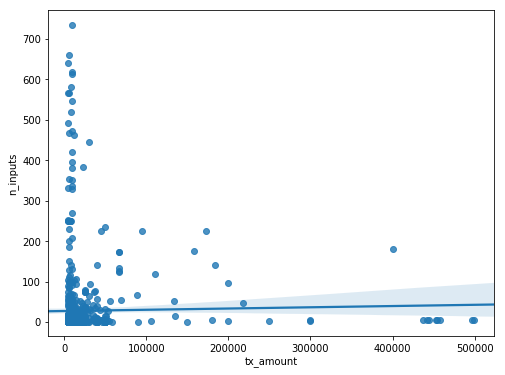

In [69]:
import matplotlib.pyplot as plt 
import seaborn as sns 

plt.figure(figsize=(8, 6))
sns.regplot(x=tx_df_1["tx_amount"], y=tx_df_1["n_inputs"])
plt.show()

In [52]:
# input 갯수가 많은 거래 
tx_df_1.sort_values(by='n_inputs').tail()

,tx_hash,n_inputs,tx_amount
499,7d348c91ea32bc3e4f9b9adbdf89080a6ca573d0c301e6...,614,9000.0
363,f8cb81f7c996d83805ea57aef41dabd15feaf09620fd71...,618,10000.0
972,109e92e8d5e38ae3d3c184d9f9de04d26234bec04dac23...,639,5000.0
776,5c72813390d9eddc3b40c1fb9e3b8bef5849ff73584c8c...,661,5906.0
494,754640b644a9e5b37be661eb68667da366c76b00064a5d...,734,9000.0


Thoughts: 

- tx_amount가 많아진다고 해서 소비되는 UTXO의 개수도 늘어나는것은 아님  
- 100,000 BTC 이상 매수한 경우 대부분 UTXO가 1개 소비됨, input, output이 모두 한개로만 이루어져 있는 경우임. 자기 자신이 소유하고 있는 다른 주소로 전체 큰 단위의 UTXO를 전송 했을 가능성이 높음.  
- 100,000 BTC 이하로 매수한 경우 UTXO의 분포가 엄청 긴 tail을 가지는 것으로 보임

그럼, 100,000BTC를 기준으로 구간을 나누어서 그래프를 다시 그려보면, 

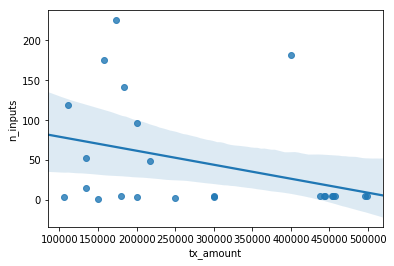

In [67]:
# 100,000 BTC 이상 매수한 경우
sns.regplot(x=tx_df_1[tx_df_1['tx_amount'] > 100000]["tx_amount"], 
            y=tx_df_1[tx_df_1['tx_amount'] > 100000]["n_inputs"])
plt.show()

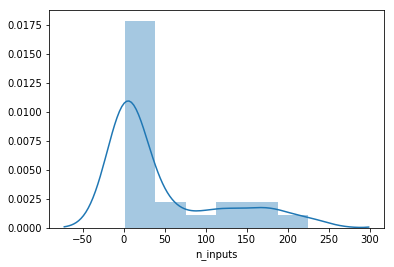

In [64]:
sns.distplot(tx_df_1[tx_df_1['tx_amount'] > 100000]['n_inputs'])
plt.show()

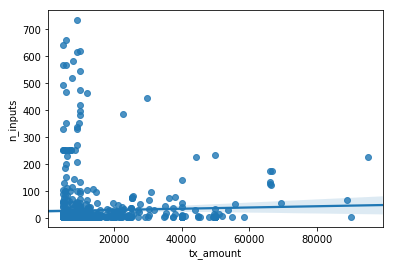

In [85]:
# 100,000 BTC이하로 매수한 경우
sns.regplot(x=tx_df_1[tx_df_1['tx_amount'] < 100000]["tx_amount"],
            y=tx_df_1[tx_df_1['tx_amount'] < 100000]["n_inputs"])
plt.show()

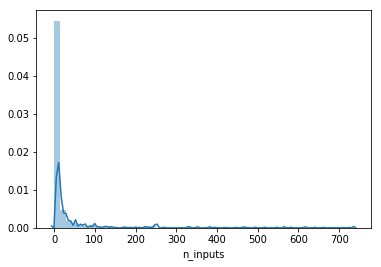

In [84]:
sns.distplot(tx_df_1[tx_df_1['tx_amount'] < 100000]['n_inputs'])
plt.show()

Conclusion: 
- 매수금액이 큰 경우(5,000BTC 이상), 금액과 input list길이는 비례 하지 않음
- 범위를 나눠서 100,000BTC 이상인 경우, 금액이 클수록 input list 길이는 줄어드는 것으로 보임. input list길이의 분포는 왼쪽으로 치우쳐 있음
- 그 이하인 경우 별다른 경향성은 없어 보임. input list의 분포는 왼쪽으로 치우쳐 있고 매우 긴 tail을 가지고 있음
- 거래 금액을 내림차순으로 정렬해서 상위 1000개만 선택했으니까, 상대적으로 소액을 매수한 케이스는 볼 수없었음. 현재 1000rows limit으로 쿼리를 실행하는데, 소액 매수는 데이터 포인트가 훨씬 많을 것이기 때문에 1000 rows로는 다양한 거래 금액 데이터 포인트를 볼 수 없을 것. 따라서 쿼터제한이 있는 지금 같은 경우 쿼리 튜닝이 필요함  

아래의 경우 1000개 모두 거래 금액이 100BTC인 경우라서 거래금액, input list길이 사이 관계 확인이 불가능

In [75]:
# query = """SELECT distinct transaction_id as tx_hash, 
#     ARRAY_LENGTH(inputs) as n_inputs, 
#     o.output_satoshis as tx_amount FROM  
#     `bigquery-public-data.bitcoin_blockchain.transactions` JOIN
#     UNNEST(outputs) as o 
#     where o.output_pubkey_base58 not in (SELECT i.input_pubkey_base58 
#     FROM UNNEST(inputs) as i) and ARRAY_LENGTH(outputs) = 1 
#     and o.output_satoshis < 10000000000
#     ORDER BY tx_amount desc limit 1000"""

# query_job = client.query(query)
# iterator = query_job.result(timeout=30)
# rows =list(iterator)

# tx_df_2 = pd.DataFrame(data=[list(x.values()) for x in rows], 
#                        columns=list(rows[0].keys()))

# # satoshis into BTC 
# tx_df_2['tx_amount'] = round(tx_df_2['tx_amount']/10**8, 3)

# # pickle 
# tx_df_2.to_pickle('tx_df_2.pkl')

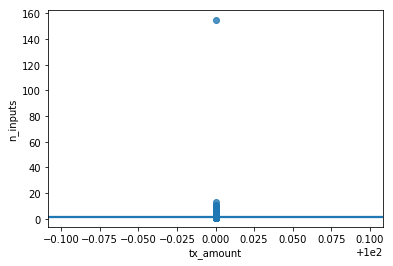

In [87]:
# sns.regplot(x=tx_df_2["tx_amount"], y=tx_df_2["n_inputs"])
# plt.show()

<a name='2-2'></a>
### 2-2. transaction amount in BTC vs. transaction count in time series

Goal: Bitcoin/USD가격이 급등하면서 거래되는 bitcoin금액과 거래 횟수가 어떻게 변화하는지 확인

In [90]:
# transaction amount in BTC 
query = """SELECT TIMESTAMP_MILLIS((timestamp - MOD(timestamp, 
        86400000))) AS date, avg(o.output_satoshis) as tx_amount_avg 
        FROM `bigquery-public-data.bitcoin_blockchain.transactions` JOIN 
        UNNEST(outputs) as o GROUP BY date ORDER BY tx_amount_avg DESC
"""

query_job = client.query(query)
iterator = query_job.result(timeout=30)
rows = list(iterator)

In [99]:
tx_date_df = pd.DataFrame(data=[list(x.values()) for x in rows], 
                       columns=list(rows[0].keys()))
tx_date_df['tx_amount_avg'] = tx_date_df['tx_amount_avg']/10**8
tx_date_df = tx_date_df.sort_values(by='date')

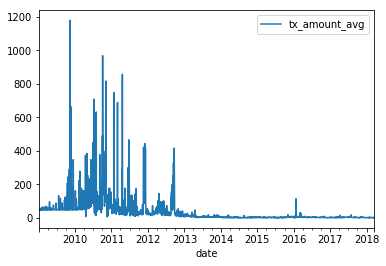

In [100]:
tx_date_df.set_index('date').plot()
plt.show()

In [103]:
# transaction count 
query = """SELECT  TIMESTAMP_MILLIS((timestamp - MOD(timestamp,
          86400000))) AS date, count(o.output_satoshis) as tx_count from 
    `bigquery-public-data.bitcoin_blockchain.transactions`JOIN
    UNNEST(outputs) as o group by date order by tx_count
"""

query_job = client.query(query)
iterator = query_job.result()
rows = list(iterator)

In [106]:
tx_cnt_df = pd.DataFrame(data=[list(x.values()) for x in rows], 
                       columns=list(rows[0].keys()))
tx_cnt_df = tx_cnt_df.sort_values(by='date')

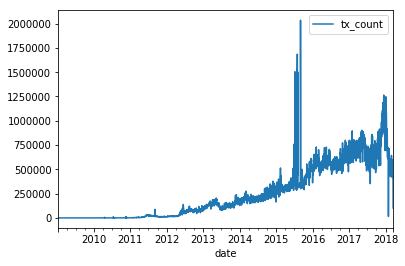

In [107]:
tx_cnt_df.set_index('date').plot()
plt.show()

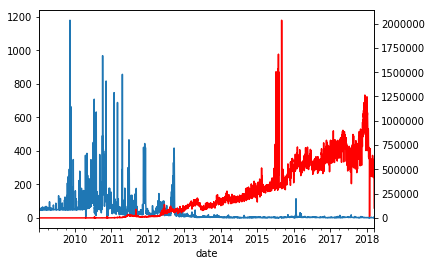

In [120]:
merged_df = pd.merge(tx_cnt_df, tx_date_df, on='date')

ax = merged_df.plot(x='date', y='tx_amount_avg', legend=False)
ax2= ax.twinx()
ax2 = merged_df.plot(x='date', y='tx_count', ax=ax2, legend=False, color='r')
plt.show()

In [130]:
print("2017 년 이후 평균 거래 금액 in BTC: ", 
      merged_df[(merged_df['date']>'2017')].tx_amount_avg.mean())

print("2013 년 동안 평균 거래 금액 in BTC: ",
    merged_df[(merged_df['date']>'2013') & (merged_df['date']<'2014') ].tx_amount_avg.mean())

2017 년 이후 평균 거래 금액 in BTC:  3.35803007994
2013 년 동안 평균 거래 금액 in BTC:  8.76137271573


Conclusion:
- Bitcoin은 인플레이션이 일어나지 않도록 그 총액이 정해져 있으므로, 2013년 이후 거래 건수가 급증함에 따라, 평균 거래 금액(BTC)도 현저하게 줄어듬
- 2013년 이후로 거래 횟수는 크게 성장 했지만, 평균 거래 금액의 경우 2013년 이후 큰 변화는 없음 

<a name='2-3'></a>
### 2-3. script가 RETURN인 transaction 살펴보기 

Goal: 
- standard transaction중, null data는 transaction 데이터에 비트코인 거래와 관계없는 데이터를 80bytes까지 넣을 수 있게 하는 거래 유형이다. 이 null data transaction의 경우 output transaction에 `RETURN` operator를 넣어서 구분함. 
- null data transaction에 입력된 데이터를 decode해서 어떤 arbitrary data가 transaction에 포함되는지 알아봄
- 나중에 digital asset이나 contract를 확인할 때 쓰일 수 있음

In [143]:
query = """SELECT distinct transaction_id as tx_id ,
    ARRAY_LENGTH(inputs) as n_inputs,
    ARRAY_LENGTH(outputs) as n_outputs,
    o.output_script_string FROM
    `bigquery-public-data.bitcoin_blockchain.transactions` JOIN
    UNNEST(outputs)as o, UNNEST(inputs) as i 
    where o.output_script_string LIKE '%RETURN%' limit 1000"""

In [144]:
query_job = client.query(query)
iterator = query_job.result(timeout=30)
rows = list(iterator)

In [145]:
null_data_df = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))

In [146]:
null_data_df.tail()

,tx_id,n_inputs,n_outputs,output_script_string
995,0d2ef6b56f876dcb2a358eba19f2bcb0eb5cb24a3244c6...,4,4,RETURN PUSHDATA(23)[4153435249424553504f4f4c30...
996,82ea621a90fdbf1d1c18c024b8c5b225d2e042efb288a3...,4,4,RETURN PUSHDATA(18)[4f4101000380dbd5fe0a80f8e4...
997,c9b51a4b6fe04ad20e91cadb255b19f71f174c6484537f...,4,4,RETURN PUSHDATA(23)[4153435249424553504f4f4c30...
998,cde437ad9f0d154f0fbdbbc147919efeba5023c32722bf...,4,4,RETURN PUSHDATA(19)[4153435249424553504f4f4c30...
999,6c8434f6ab374b6d3768d2f8c79b5bcfaecf01d15e6020...,4,6,RETURN PUSHDATA(16)[4f41010002a0cf96d816d0b4dd...


In [186]:
import binascii
import numpy as np
null_data_df['arbitrary_data'] = null_data_df.output_script_string.str.extract('.*\[(.*)\]')
null_data_df['arbitrary_data_decoded'] = null_data_df.apply(lambda x: binascii.unhexlify(x.arbitrary_data) if x.arbitrary_data is not np.nan else np.nan, axis=1)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  This is separate from the ipykernel package so we can avoid doing imports until


In [195]:
null_data_df.to_pickle('null_data_df.pkl')

In [197]:
# Decoded Arbitrary Data 
null_data_df.arbitrary_data_decoded.tail(20)

980    b'omni\x00\x00\x00\x00\x00\x00\x00\x1f\x00\x00...
981    b'omni\x00\x00\x00\x00\x00\x00\x00\x1f\x00\x00...
982    b'omni\x00\x00\x00\x00\x00\x00\x00\x1f\x00\x00...
983    b'omni\x00\x00\x00\x00\x00\x00\x00\x1f\x00\x00...
984    b'id:m1000.id\x00\x00\x00\x00\x00\x00\x00\x00\...
985    b'OA\x01\x00\x04\xc6\xfe\x16\xbc\xf3\xb4\x01\x...
986    b'\x80m\xe7C\xb9\xf0P\xd6\x9b\x82+\x0c,\xbe?\x...
987    b'omni\x00\x00\x00\x00\x00\x00\x00\x1f\x00\x00...
988    b'H;\xa6\xff\xa7&\xb7V\x11x\x04\xa3`\x9fZ\x17\...
989    b'\x13\xe8\xa0\xa4&NU\x1e\x1e\xb3\n\x95\xbb\xe...
990                          b'2NOmHXmcIp3R/G2E8THPrA=='
991                                b'ASCRIBESPOOL01FUEL'
992                           b'ASCRIBESPOOL01EDITIONS1'
993                           b'ASCRIBESPOOL01EDITIONS2'
994                                b'ASCRIBESPOOL01FUEL'
995                           b'ASCRIBESPOOL01EDITIONS0'
996    b'OA\x01\x00\x03\x80\xdb\xd5\xfe\n\x80\xf8\xe4...
997                           b

Conclusion: 
    - RETURN operator에 적힌 데이터를 추출 해 내는 것은 단순 정규식으로도 가능함
    - RETURN 뒤에 추가 데이터를 쓰지 않은 경우도 있음
    - decode해서 plain english로 알아 들을 수 있는 경우(예를 들어 ASCRIBESPOOL01PIECE)도 있지만 이해관계에 없는 사람은 이해 할 수 없는, 암호화 된 데이터도 쉽게 해석 할 수 없는 경우도 많다